In [13]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import copy
import numpy as np
%matplotlib inline
from pylab import *
import os
import pandas as pd

In [2]:
from colossus.cosmology import cosmology

In [3]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [4]:
#Modificando la cosmología

cosmo.Om0=0.29
cosmo.Omde=0.71
cosmo.ns=0.97
cosmo.H0=70
cosmo.relspecies=False
cosmo.checkForChangedCosmology()
print(cosmo)

Cosmology: Detected change in cosmological parameters.
Cosmology "planck15" 
    flat = True, Om0 = 0.2900, Ode0 = 0.7100, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9700
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [5]:
Pk_=cosmo.matterPowerSpectrum

In [6]:
pk_cmasdr12=np.loadtxt("/Users/stefany/Desktop/analisisdatos/da2019-Stefany2889/datos/GilMarin_boss_data/post-recon/cmass/GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt").T

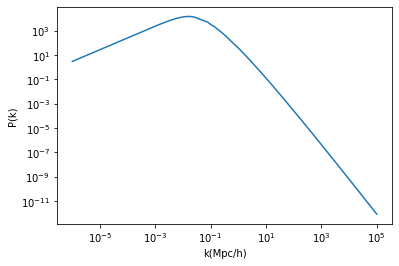

In [7]:
k=10**np.linspace(-6,5,100000)
Pk=cosmo.matterPowerSpectrum(k,0.57)

plt.figure()
plt.loglog()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-')

3

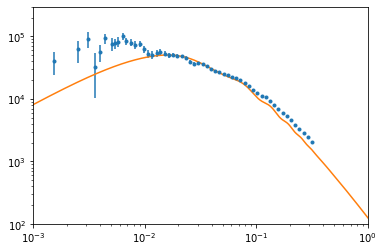

In [8]:
plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0],pk_cmasdr12[1], yerr=pk_cmasdr12[2], fmt='.' )
plt.plot(k, 1.85 **2 * Pk, '-')
plt.xlim(1e-3,1)
plt.ylim(100,3e5)

len(pk_cmasdr12)

In [9]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

def Pk_Om(Om_,b2, k, z):
    cosmo.Om0=Om_
    b=np.abs(np.sqrt(b2))
    
    A=b2*(1+((Om_**0.55)/b))
    
    return A*cosmo.matterPowerSpectrum(k,z)    #Nos da el Pk y el A

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [10]:
def chisq(theta, data):                 # Donde theta son los datos que se generan a aprtir del montecarlo 
    x= data[0]                          
    y= data[1]
    yerr= data[2]
    om=theta[0]
    b2=theta[1]
    
    z=theta[2]
    if    0.1>om>1.0 and b2< 0.1 and b2 > 25:
        
        chisq=np.inf
            
    else:
        
        model= Pk_Om(theta[0],theta[1], x, z)
        chisq= (y-model)**2 / yerr**2
       
    return chisq.sum()

def comparacion(chisq_ini, chisq_new):  #funcioón para comparar los modelos
    a=np.log(np.random.uniform(0,1))
    
    if chisq_new < chisq_ini:
        chisq_ini= chisq_new
        acc=True
        
    elif (chisq_ini-chisq_new) > a:
        chisq_ini= chisq_new
        acc=True
    
    else: 
        chisq_ini= chisq_ini
        acc=False
            
    return chisq_ini, acc

#def montecarlo(x_ini, y_ini, data, s2, n):  #donde s2 esel sigma cuadrada
def montecarlo(theta, data, s2, n):  #theta son los valores que inician la busqueda(parametros a ajustar), 
                                    #data son los datos experimentales        
                                    #s2 esel sigma cuadrada
            
    x_=data[0][10:45]
    y_=data[1][10:45]
    err_=data[2][10:45]
    
    chisqr_stor=np.zeros(n)
    x=np.zeros(n)
    y=np.zeros(n)
    k=0    #Contador devalores acepados    (Para este caso x sera omega y y sera b2)
    beta=np.zeros(n)
    
    param0_ini= theta[0]   #x_ini
    param1_ini= theta[1]   #y_ini
    param2_ini= theta[2]    #z
    

    for i in range(n):
    
        x[i]=param0_ini
        b=np.abs(np.sqrt(param1_ini))
        y[i]=b
        beta[i]=((param0_ini**0.55)/b)
        
        x_new =s2* np.random.randn()+ param0_ini
        y_new =s2* np.random.randn()+ param1_ini   #Se generan los nuevos pares de parámetros
        
        
        chisqr_ini=chisq([param0_ini,param1_ini, param2_ini], data)
        
        chisqr_stor[i]= chisqr_ini
        
        
        chisqr_new=chisq([x_new,y_new, z], data)
        
          
            

        chisq_comp,acc= comparacion(chisqr_ini, chisqr_new)
            
            
        if acc is not True: # == chisqr_ini:
            param0_ini=param0_ini
            param1_ini=param1_ini
        else:
            param0_ini=x_new
            param1_ini=y_new
            k= k + 1
        
   
    return x, y, beta, chisqr_stor, k
    

In [11]:
Om_ini=0.7
b2_ini=0.4
z=0.57 
n=10000
    
pk_prueba= montecarlo([0.5, 0.6, z], pk_cmasdr12, 0.005, n)

param1=pk_prueba[0]
k=pk_prueba[4]
k

1962

No handles with labels found to put in legend.


0.1962

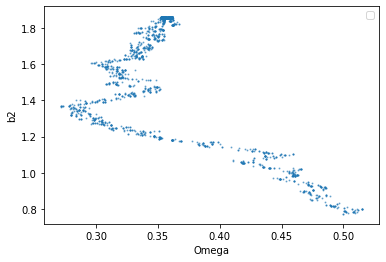

In [12]:
scat=plt.scatter(pk_prueba[0], pk_prueba[1], s=1, alpha=0.5) #, label= 'caminante {0}'.format(i))
#plt.xlim(-1.25,-0.75)
#plt.ylim(5,6)
plt.xlabel('Omega')
plt.ylabel('b2')
plt.legend(frameon = True)
k=pk_prueba[4]
acc=k/n
acc

(array([  22.,  231., 1207., 1913.,    0.,    0., 1118., 2020.,  434.,
          55.]),
 array([0.35193186, 0.35292668, 0.3539215 , 0.35491631, 0.35591113,
        0.35690595, 0.35790077, 0.35889559, 0.35989041, 0.36088523,
        0.36188004]),
 <a list of 10 Patch objects>)

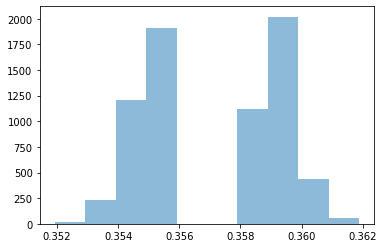

In [13]:
omega=pk_prueba[0]
b2=pk_prueba[1]
beta=pk_prueba[2]
burning=n*(0.3)
bur=int(burning)
bur
plt.hist(omega[bur:], alpha=0.5)
    

    


(array([ 252.,  432.,  692., 1610., 1724., 1214.,  734.,  273.,   60.,
           9.]),
 array([1.85327328, 1.85416279, 1.8550523 , 1.85594182, 1.85683133,
        1.85772085, 1.85861036, 1.85949988, 1.86038939, 1.8612789 ,
        1.86216842]),
 <a list of 10 Patch objects>)

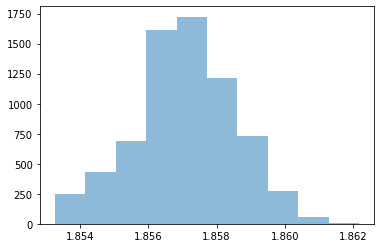

In [14]:
plt.hist(b2[bur:], alpha=0.5)

(array([  94.,  355., 1889.,  933.,  102.,  231., 1792., 1304.,  264.,
          36.]),
 array([0.30342061, 0.30387662, 0.30433263, 0.30478864, 0.30524464,
        0.30570065, 0.30615666, 0.30661267, 0.30706867, 0.30752468,
        0.30798069]),
 <a list of 10 Patch objects>)

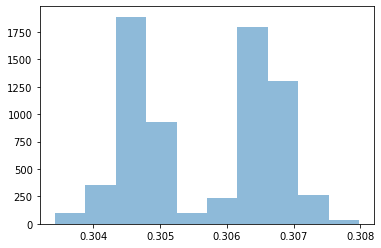

In [15]:
plt.hist(beta[bur:], alpha=0.5)

In [16]:
bur

3000

In [11]:
Om_ini=0.7
b2_ini=0.4
z=0.57 
n=10000
    
pk_prueba= montecarlo([0.5, 0.6, z], pk_cmasdr12, 0.005, n)

param1=pk_prueba[0]
k=pk_prueba[4]
k

param= []
for i in range (5):
    
    pk_prueba= montecarlo([0.5, 0.6, z], pk_cmasdr12, 0.005, n)
    
    param.append(pk_prueba)

param1=param[1]
k=param1[3]
k

array([150558.57418737, 150558.57418737, 150558.57418737, ...,
          344.98197279,    344.98197279,    344.98197279])

In [16]:
mean(k)

7956.341094973495

array([0., 0., 0., 0., 0.])

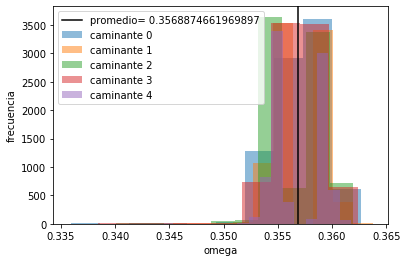

In [39]:


omega_mean=np.zeros(5)
for i in range (5):
    omega_c= param[i]
    omega_=omega_c[0]
    omega_mean[i]=mean(omega_[1500:])
    plt.hist(omega_[1500:], alpha=0.5, label= 'caminante {0}'.format(i))
    

omega_sum=sum(omega_mean)
omega_prom=omega_sum/5

plt.axvline(omega_prom, color = 'black', label = 'promedio= {0}'.format(omega_prom))
plt.xlabel('omega')
plt.ylabel('frecuencia')
plt.legend(frameon = True)
a_mean



10000 10000
10000 10000
10000 10000
10000 10000
10000 10000


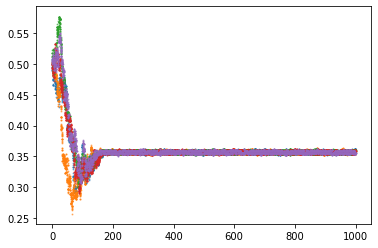

In [40]:
x = np.linspace(0, 1000,10000)

for i in range (5):
    omega_c= param[i]
    omega_=omega_c[0]
    omega_mean[i]=mean(omega_[1500:])
    plt.scatter(x,omega_,  s=1, alpha=0.5 )
    print(len(omega_), len(x))


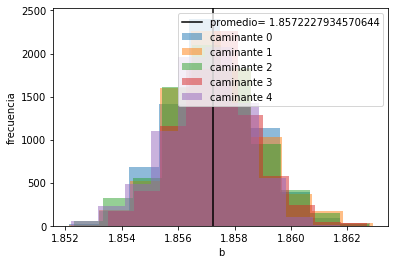

In [41]:
b_mean=np.zeros(5)
for i in range (5):
    b_c= param[i]
    b_=b_c[1]
    b_mean[i]=mean(b_[2000:])
    plt.hist(b_[2000:], alpha=0.5, label= 'caminante {0}'.format(i))

b_sum=sum(b_mean)
b_prom=b_sum/5

plt.axvline(b_prom, color = 'black', label = 'promedio= {0}'.format(b_prom))
#plt.axvline(b, color = 'black', label = 'b_real')
plt.xlabel('b')
plt.ylabel('frecuencia')
plt.legend(frameon = True)

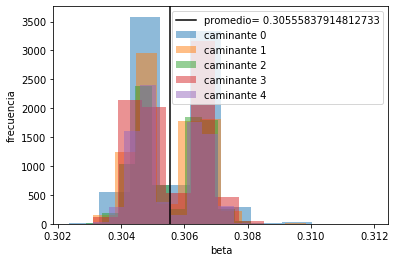

In [45]:

beta_mean=np.zeros(5)
for i in range (5):
    beta_c= param[i]
    beta_=beta_c[2]
    beta_mean[i]=mean(beta_[1500:])
    plt.hist(beta_[1500:], alpha=0.5, label= 'caminante {0}'.format(i))

beta_sum=sum(beta_mean)
beta_prom=beta_sum/5

plt.axvline(beta_prom, color = 'black', label = 'promedio= {0}'.format(beta_prom))
#plt.axvline(b, color = 'black', label = 'b_real')
plt.xlabel('beta')
plt.ylabel('frecuencia')
plt.legend(frameon = True)


Para los casos donde las variables son (b, beta, omega), (A, omega), (b, omega,beta(omega, b)))

In [ ]:

for i in range (5):
    omega_c= param[i]
    omega_=a_c[2]
    omega_mean[i]=mean(omega_[1500:])
    plt.scatter(x,omega_,  s=1, alpha=0.5 )
    print(len(omega_), len(x))